# Using fastai's u-net with resnet34 for image segmentation of jpg satellite images 
Follow the example of "SpaceNEt7 sample code" notebook 

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.8.1+cu101
True
1


In [6]:
#hide
!pip install fastcore==1.3.19 fastai==2.2.5 rasterio geopandas shapely wandb -Uqq

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 194kB 13.1MB/s 
     |████████████████████████████████| 19.1MB 289kB/s 
     |████████████████████████████████| 1.0MB 51.0MB/s 
     |████████████████████████████████| 1.8MB 48.5MB/s 
     |████████████████████████████████| 12.8MB 28.1MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 15.3MB 283kB/s 
     |████████████████████████████████| 6.5MB 31.0MB/s 
     |████████████████████████████████| 133kB 57.9MB/s 
     |████████████████████████████████| 102kB 16.0MB/s 
     |████████████████████████████████| 174kB 58.2MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [4]:
from fastai.vision.all import *
from tqdm import tqdm #progress bars 
from pdb import set_trace
from pprint import pprint

import wandb #tracks and saves model parameters and performance
from fastai.callback.wandb import *

warnings.filterwarnings("ignore")

ModuleNotFoundError: ignored

In [5]:
#make sure you're using version 2 of fastai (2.2.5)
import fastai
print(fastai.__version__)

1.0.61


In [1]:
#mount my personal colabgoogle drive to this notebook. To use local files, you have to run colab from your local runtime
from google.colab import drive
drive.mount('/content/drive')

#create path object that is in your google drive 
path = Path('/content/drive/MyDrive/AOI_5') 
Path.BASE_PATH = path

img_ext = "images" #images or local/global_contrasted_images
mask_ext = "masks"
img_dir = path/img_ext
mask_dir = path/mask_ext

#folder system: 
#DSC 449 Project
#-Test
#--GeoJson
#--images
#-Train
#--GeoJson
#--images

Mounted at /content/drive


NameError: ignored

In [ ]:
3# Checking what Google Colab is offering today :)
try:
  print(torch.cuda.get_device_properties(0))
except:
  print("No CUDA device available.")

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


### Prep: Set training parameters

In [ ]:
BATCH_SIZE = 3 #For his 255*255 images, 12 for xresnet34 with Tesla P100 (16GB)
ARCHITECTURE = xresnet34 #resnet34 was imported with all the other models with fastai.vision.all import * 
EPOCHS = 40
CLASS_WEIGHTS = [0.25,0.75]
LR_MAX = 1e-4
ENCODER_FACTOR = 10
CODES = ['Land','Building']

In [ ]:
#hide
# Weights and Biases config
config_dictionary = dict(
    bs=BATCH_SIZE,
    architecture = str(ARCHITECTURE),
    epochs = EPOCHS,
    class_weights = CLASS_WEIGHTS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR
)

### Show that the test and train folders are connected 

In [ ]:
images_masked = img_dir.ls().sorted()
labels = mask_dir.ls().sorted()
print(f'Numer of images in images: {len(images_masked)}')
pprint(list(images_masked[:5]))

Numer of images in images: 1012
[Path('global_contrasted_images/RGB-PanSharpen__32.4858384_15.5138111999.jpg'),
 Path('global_contrasted_images/RGB-PanSharpen__32.4858384_15.5155661999.jpg'),
 Path('global_contrasted_images/RGB-PanSharpen__32.4858384_15.5173211999.jpg'),
 Path('global_contrasted_images/RGB-PanSharpen__32.4875934_15.5138111999.jpg'),
 Path('global_contrasted_images/RGB-PanSharpen__32.4875934_15.5155661999.jpg')]


## Visualize your masks 
...to make sure get_y_fn works 

In [ ]:
def get_y_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('/images/', '/masks/').replace('jpg','png')

def get_y(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_y_fn(fn)
  msk = np.array(PILMask.create(fn))
  msk[msk==255] = 1                          #assume Binary masking!!! 
  return PILMask.create(msk)


In [ ]:
get_y_fn(images_masked[5])

'/content/drive/MyDrive/AOI_5/masks/RGB-PanSharpen__32.4875934_15.5190761999.png'

In [ ]:
#Get a random sample 
def show_tiles(n):
  all_tiles = get_image_files(img_dir)
  subset = random.sample(all_tiles, n)
  fig, ax = plt.subplots(n//2, 4, figsize=(14,14))
  for i in range(n):
    y = i//2
    x = 2*i%4
    PILImage.create(subset[i]).show(ctx=ax[y, x])
    get_y(subset[i]).show(ctx=ax[y, x+1], cmap='cividis')
  fig.tight_layout()
  plt.show()

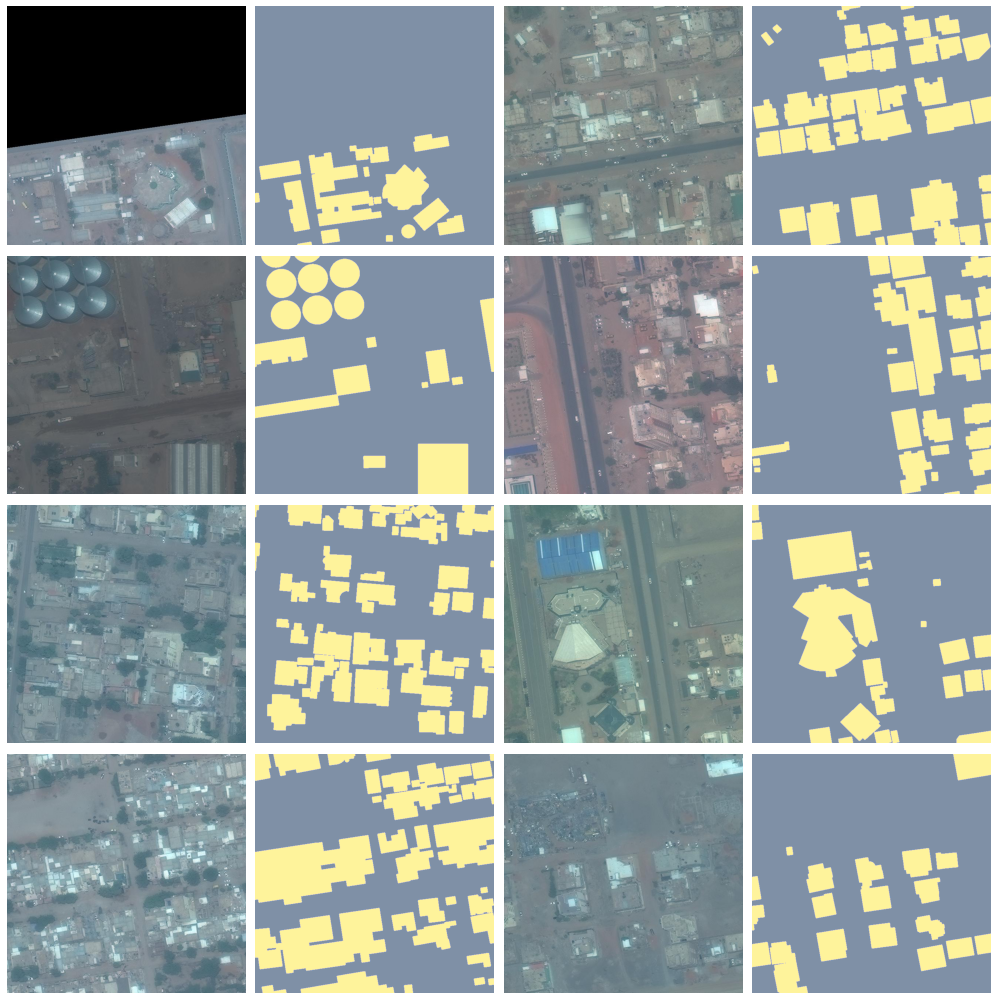

In [ ]:
show_tiles(8)

### EDA: how many images have no buildings 

In [ ]:
#Test set data loader 
data = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)),
      get_items = get_image_files,
      get_y = get_y
    )    
          
init_dls = data.dataloaders(img_dir, bs=BATCH_SIZE)
init_dls.vocab = CODES


In [ ]:
targs = torch.zeros((0,650,650)) #size of img
for _, masks in init_dls[0]:
  targs = torch.cat((targs, masks.cpu()), dim=0)
targs.shape

torch.Size([804, 650, 650])

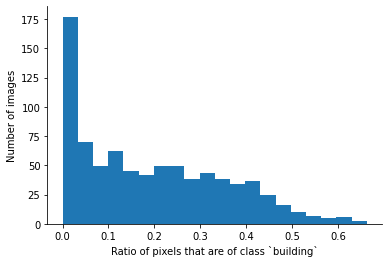

In [ ]:
#For the training dataset 
total_pixels = targs.shape[1]**2
percentages = torch.count_nonzero(targs, dim=(1,2))/total_pixels
plt.hist(percentages, bins=20)
plt.ylabel('Number of images')
plt.xlabel('Ratio of pixels that are of class `building`')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.show()

In [ ]:
#how many images in our training set have 0 buildings: 
torch.count_nonzero((percentages==0.).float()).item()

69

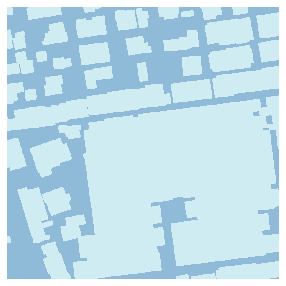

In [ ]:
#Show the image with the largest percentage of buildings in training set 
targs[percentages.argsort(descending=True)[0]].show();

In [ ]:
#Overal building to background percentage 
print(percentages.mean().item(), percentages.median().item())

0.19181287288665771 0.16182485222816467


# Create Data Loader for training and testing sets. 
Include undersampling functions for training set only 

Also include data augmentation 

In [ ]:
# Get the list of training images from the shared drive 
validation_dir = "/content/drive/MyDrive/DSC 449 Project/Train_Test_Split/images/Test/"
valid_list = os.listdir(validation_dir)
len(valid_list)

202

In [ ]:
#predefined validation splite 
def valid_split(item):
    #returns true or false whether an item is predetermined to be in validation set 
  img_fn = item.name
  return img_fn in valid_list #valid_list from above. List of file names in the validation img set 

In [ ]:
def has_buildings(fn:Path) -> bool:
    """Returns whether the mask of a given image tile
    contains at least one pixel of a building"""
    fn = get_y_fn(fn)
    msk = tensor(PILMask.create(fn))
    count = torch.count_nonzero(msk)
    return count>0.0

def get_undersampled_files(path:Path) -> L:
    files = get_image_files(path) #built in function "get_images_files()" gets all images in the given path 
    train_idxs, valid_idxs = FuncSplitter(valid_split)(files)  #predetermined validation set 
    train_files = L(filter(has_buildings, files[train_idxs])) #filter out all indexes for which "has_buildings()" function returns False 
    valid_files = files[valid_idxs]
    return train_files + valid_files

In [ ]:
def get_y_fn(fn:Path) -> str:
    "Returns filename of the associated mask tile for a given image tile"
    return str(fn).replace(f'/{img_ext}/', f'/{mask_ext}/').replace('.jpg', '.png')

def get_y(fn:Path) -> PILMask:
    "Returns a PILMask object of 0s and 1s for a given tile"
    fn = get_y_fn(fn)
    msk = np.array(PILMask.create(fn))
    msk[msk==255] = 1                    #assume a binary mask! 
    return PILMask.create(msk)

In [ ]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2),
        Normalize.from_stats(*imagenet_stats)]

In [ ]:
#Train: remove non-building images and do data augmentation 
data = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)), # Independent variable is Image, dependent variable is Mask
      get_items = get_undersampled_files,             # Collect undersampled tiles
      get_y = get_y,                                  # Get dependent variable: mask
      splitter = FuncSplitter(valid_split),           # Random split into training and validation set
      batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
    )

In [ ]:
#dataloaders 
dls = data.dataloaders(img_dir, bs=BATCH_SIZE)
dls.vocab = CODES

In [ ]:
#Should be 744:202 
len(dls.train_ds), len(dls.valid_ds)

(744, 202)

In [ ]:
#Verify the batch size and the color channels 
#images should be 3x650x650, and target 650x650
inputs, targets = dls.one_batch()
inputs.shape, targets.shape

(torch.Size([3, 3, 650, 650]), torch.Size([3, 650, 650]))

In [ ]:
#target should binary map of 0 and 1. on GPU 
targets[0].unique()

TensorMask([0, 1], device='cuda:0')

## Defining the Model

In [ ]:
weights = Tensor(CLASS_WEIGHTS).cuda() #class weights were 0.25 and 0.75 to put more emphasis on small buildings 
loss_func = CrossEntropyLossFlat(axis=1, weight=weights) #define the loss function as "flat" cross entropy loss for 1 class problem 

In [ ]:
#load the resnet34 architecture and build the unet learner 
learn = unet_learner(dls,                                 # DataLoaders
                     ARCHITECTURE,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  # Custom metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )]
                     )

In [ ]:
#Summary of the model 
learn.summary()

DynamicUnet (Input shape: 3)
Layer (type)         Output Shape         Param #    Trainable 
                     3 x 32 x 325 x 325  
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     3 x 64 x 325 x 325  
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               

In [ ]:
#Full U-Net architecture
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): ConvLayer(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ConvLayer(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): ResBlock(
          (convpath): Sequential(
            (0): ConvLayer(
              (0): Conv2d(64, 64, kernel_size=(

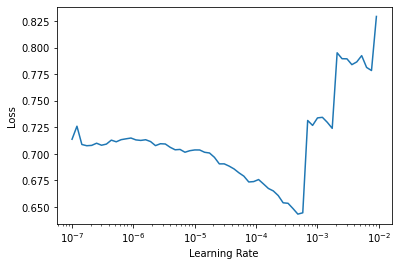

In [ ]:
#We can use fastai's learning rate finder to pick a reasonable learning rate:
learn.lr_find(suggestions=False)

In [ ]:
lr_max = LR_MAX # 1e-4

In [ ]:
#Start the weights and biases session to save model parameters and view training dashboard
wandb.init(project="space", entity="sgass", config=config_dictionary)

wandb: Currently logged in as: sgass (use `wandb login --relogin` to force relogin)


In [ ]:
#Train the model for the number of epochs specified before 
learn.unfreeze() #unfreeze the encoder model parameters to train the full network

learn.fit_one_cycle(
    EPOCHS,
    lr_max=slice(lr_max/ENCODER_FACTOR, lr_max), #train the encoder at a slower rate than the decoder b/c it's already had some training on imagenet 
    cbs=[WandbCallback()]
)

Better model found at epoch 0 with dice value: 0.5388963134633356.
Better model found at epoch 1 with dice value: 0.5859272339519188.
Better model found at epoch 2 with dice value: 0.6294151307251498.
Better model found at epoch 6 with dice value: 0.6364987819089704.
Better model found at epoch 10 with dice value: 0.7638756607425654.


In [ ]:
#Save this model on weights and bias's website 
learn.save(os.path.join(wandb.run.dir, "csc449_global_contrast"))

Path('/content/wandb/run-20210512_180407-1qeaqnob/files/csc449_global_contrast.pth')

In [ ]:
#end weights and biases section
wandb.finish()

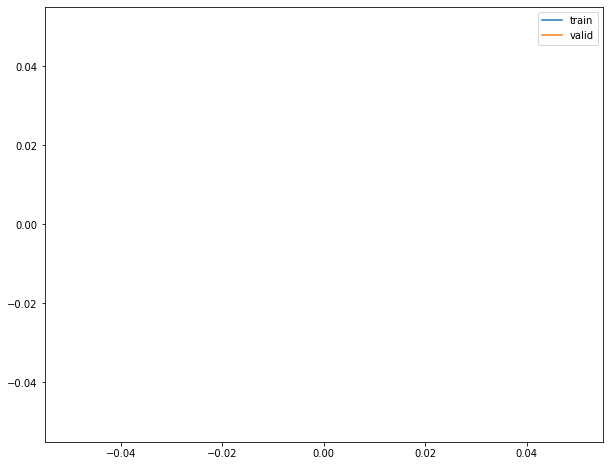

In [ ]:
plt.figure(figsize=(10,8))
learn.recorder.plot_loss()

### Get all predictions from the best performing model 

In [ ]:
learn.load('best-model');

In [ ]:
probs,targets,preds,losses = learn.get_preds(dl=dls.valid,
                                             with_loss=True,
                                             with_decoded=True,
                                             act=None)

In [ ]:
loss_sorted = torch.argsort(losses, descending=True)
n = len(loss_sorted)
n

202

In [ ]:
pred_ext = 'globalc_preds'
prob_ext = 'globalc_probs'

In [ ]:
#save the prediction maps in their own directory 

#make the directory
img_dir_out = path/pred_ext
if not os.path.exists(img_dir_out):
    os.makedirs(img_dir_out)

#loop through all images in validation set 
for idx in range(n):

    #get prediction and the file name 
    file = str(dls.valid_ds.items[idx]).replace(img_ext,pred_ext) #from masks filename: like "RGB-PanSharpen__32.5016334_15.5506661999.jpg"
    img = preds[idx].cpu().numpy()

    #convert between 0 and 255
    img = img / np.max(img)
    img *= 255

    #change data type from the geotiff default float64
    img = img.astype(np.uint8)

    im = Image.fromarray(img)
    im.save(file)


In [ ]:
#save the probability maps in their own directory 

#make the directory
img_dir_out = path/prob_ext 
if not os.path.exists(img_dir_out):
    os.makedirs(img_dir_out)

#loop through all images in validation set 
for idx in range(n):

    #get prediction and the file name 
    file = str(dls.valid_ds.items[idx]).replace(img_ext,prob_ext) #from masks filename: like "RGB-PanSharpen__32.5016334_15.5506661999.jpg"
    img = probs[idx][1].cpu().numpy() #from probs or preds 

    #convert between 0 and 255
    img = img / np.max(img)
    img *= 255

    #change data type from the geotiff default float64
    img = img.astype(np.uint8)

    im = Image.fromarray(img)
    im.save(file)

In [ ]:
#collapse
def show_single_pred(index:int):
  fig, ax = plt.subplots(1, 4, figsize=(20,5))
  dls.valid_ds[index][0].show(ctx=ax[0]);
  ax[0].set_title("Input")
  show_at(dls.valid_ds, index, cmap='Blues', ctx=ax[1]);
  ax[1].set_title("Target")
  preds[index].show(cmap='Blues', ctx=ax[2]);
  ax[2].set_title("Prediction Mask")
  probs[index][1].show(cmap='viridis', ctx=ax[3]);
  ax[3].set_title("Building class probability")

Tile #200, loss: 0.3025963306427002
Tile #199, loss: 0.27670902013778687
Tile #21, loss: 0.22354766726493835


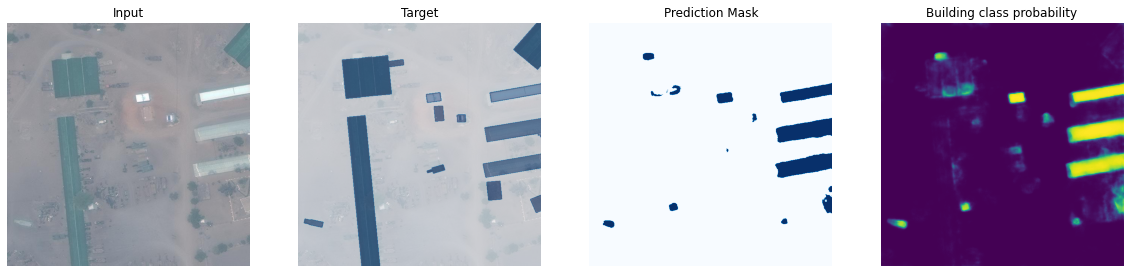

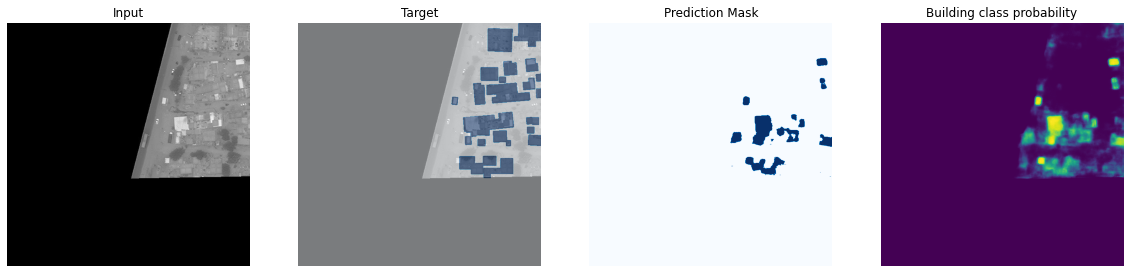

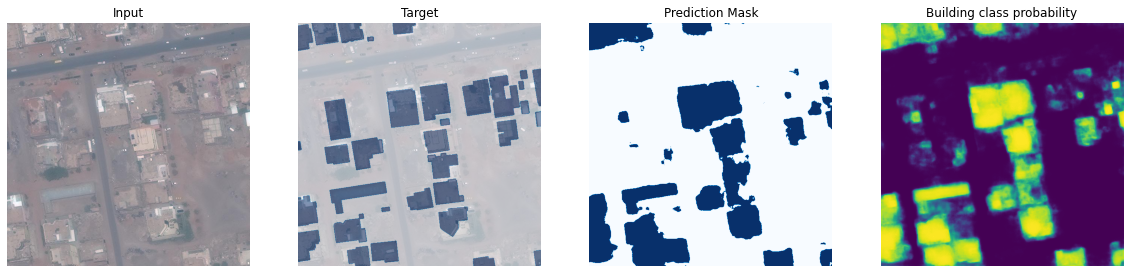

In [ ]:
#Samples with the highest loss 
for idx in loss_sorted[:3]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

Tile #124, loss: 0.05799326300621033
Tile #187, loss: 0.057859163731336594
Tile #76, loss: 0.05721167102456093


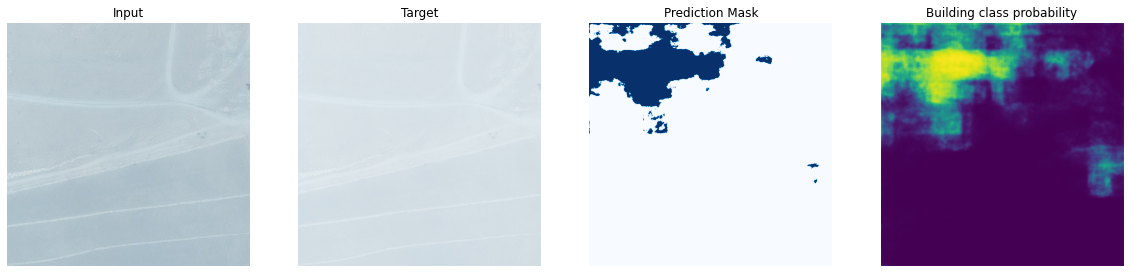

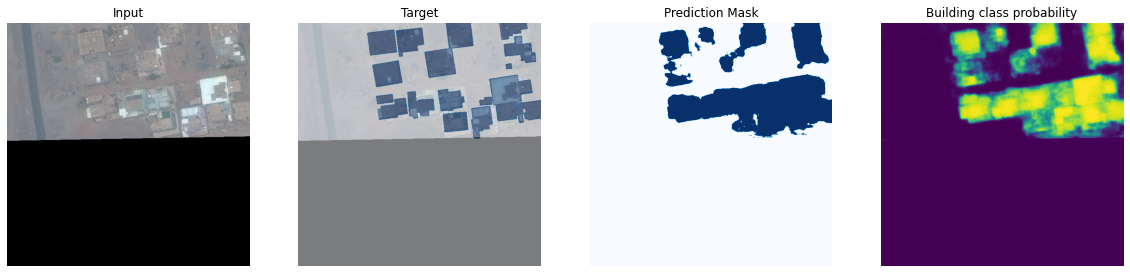

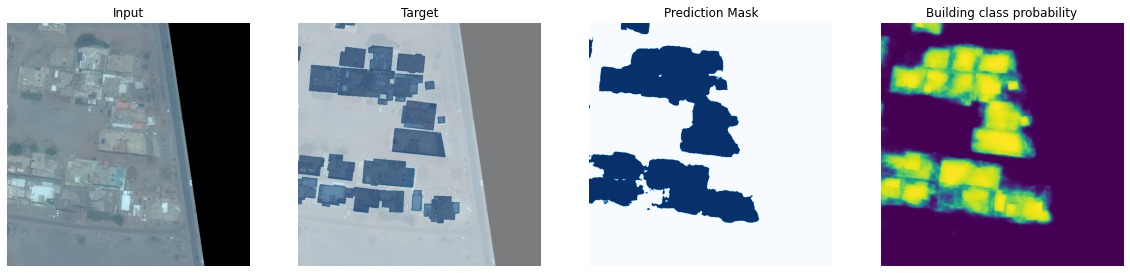

In [ ]:
#Samples with the median loss 
for idx in loss_sorted[n//2-1:n//2+2]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

Tile #123, loss: 0.0012013479135930538
Tile #122, loss: 0.0010114287724718451
Tile #120, loss: 0.0009995873551815748


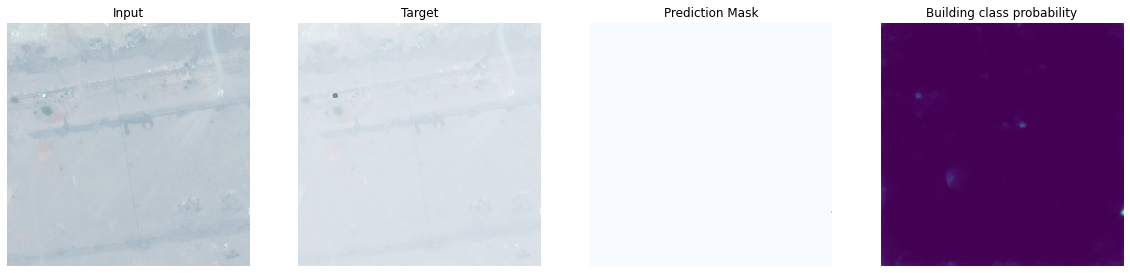

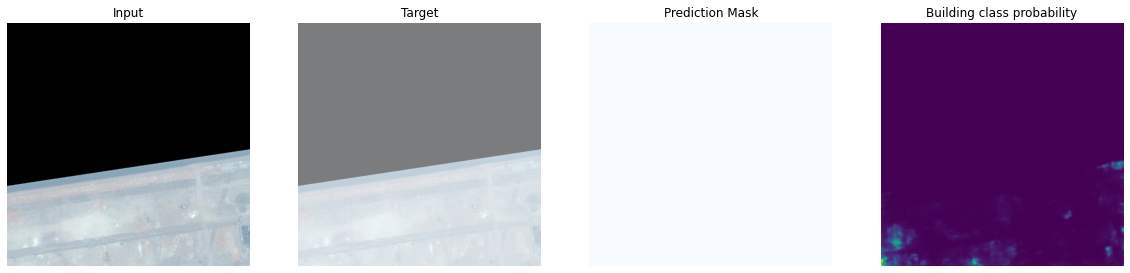

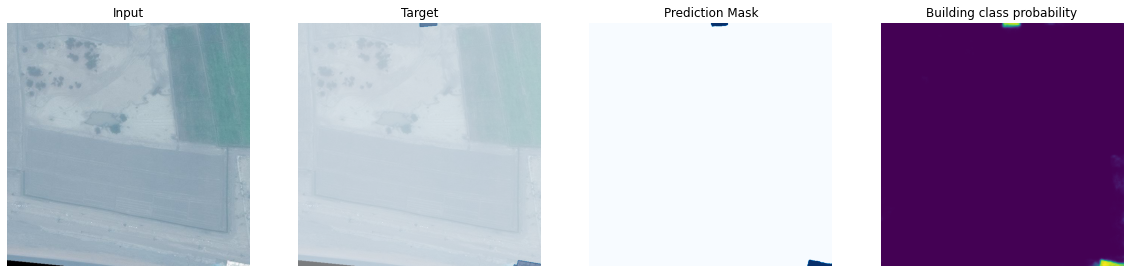

In [ ]:
#Samples with the lowest loss
for idx in loss_sorted[-21:-18]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

Tile #178, loss: 0.05648411065340042
Tile #76, loss: 0.05592098459601402
Tile #193, loss: 0.055227506905794144
Tile #130, loss: 0.05271755903959274
Tile #30, loss: 0.050128016620874405
Tile #170, loss: 0.04996395856142044
Tile #115, loss: 0.04952351376414299


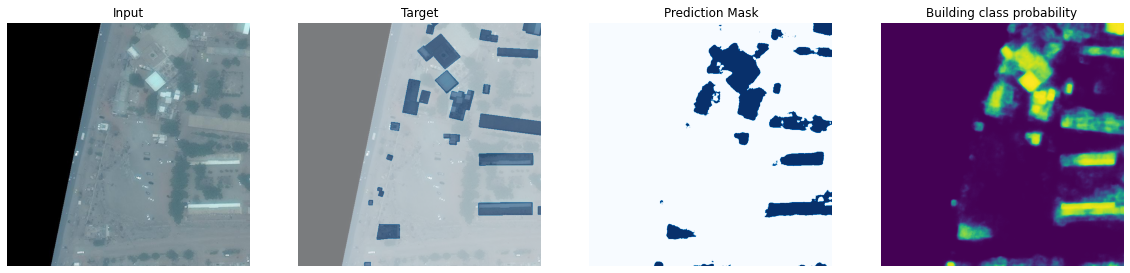

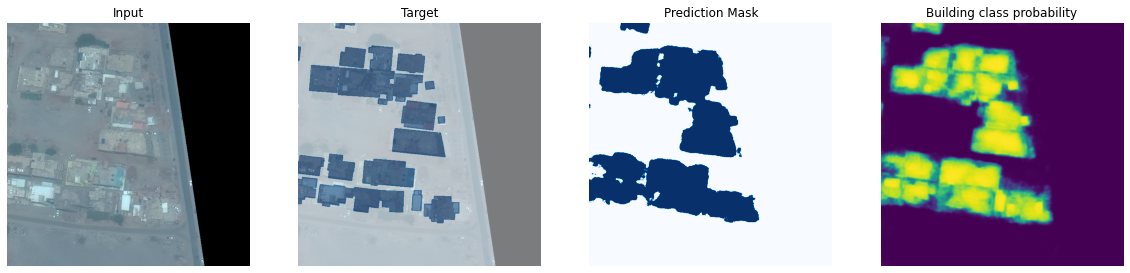

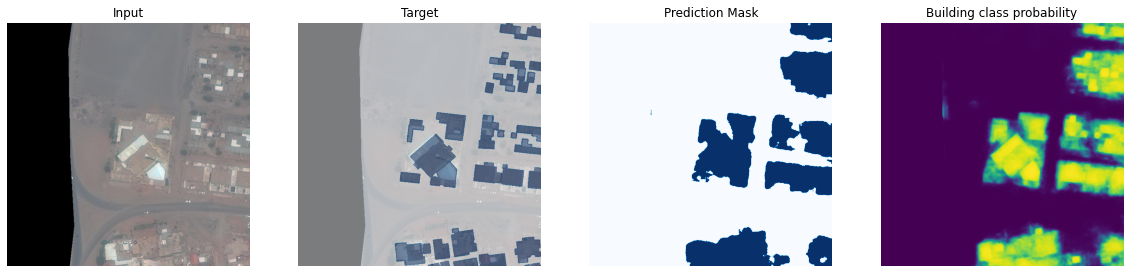

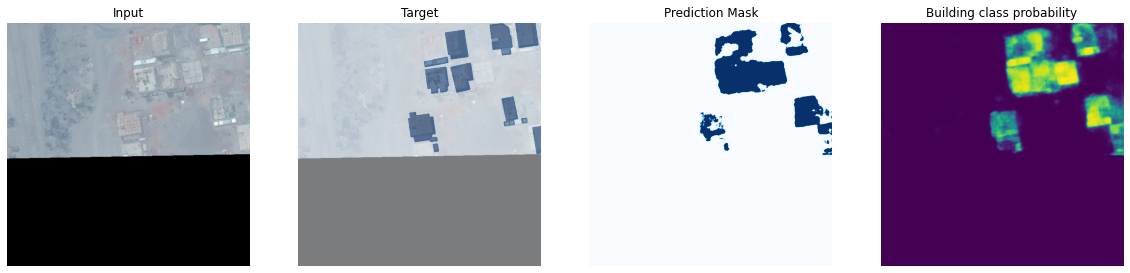

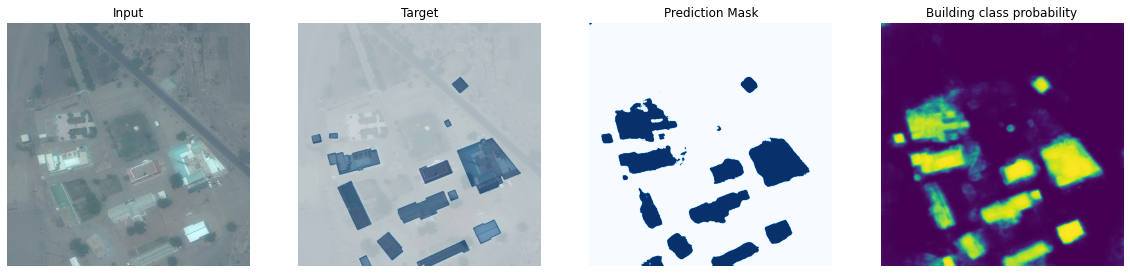

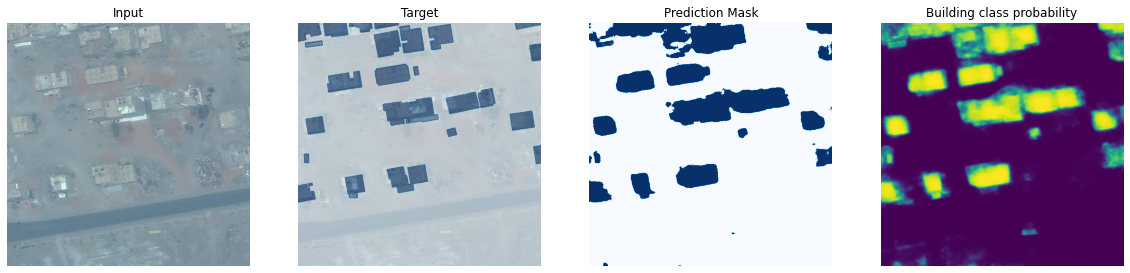

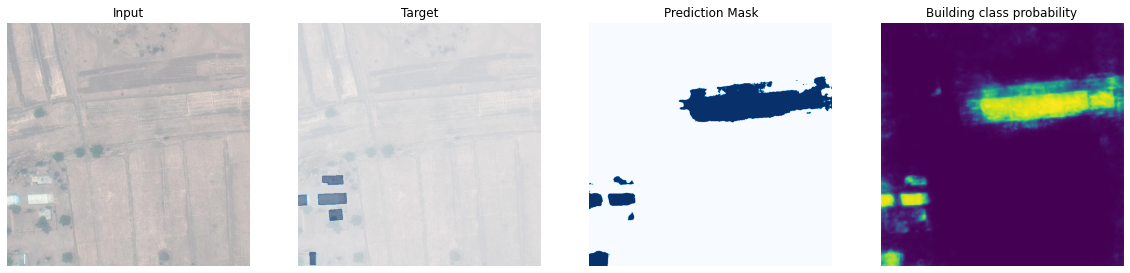

In [ ]:
#Get even more samples
i = 6 
for idx in loss_sorted[n//2-1:n//2+i]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

TO DO: 
- What is final output of our project!? How to post-process this result to compare with the bounding box method? 
- How can you compare this model's performance with the other's from SpaceNet? 
- Can you build a regression model to population from these footprint predicitons?
- If you have time, train with alternative masks. 